Serval chnages has been made to network architecture as:
* For **CFO Network**, it becomes an RNN model (2 Bi-LSTMs layers) with Multi-to-One  architecture.
* For **Channel Estimation Network**, it becomes an RNN model (2 Bi-LSTMs layers) with Multi-to-One architecture.
* For **Equalization and ECC network**, we merge into one RNN model with 2 Bidirectional LSTMs layers.


Interesting notes:

* I observe that the CFO Net starts to converge first, then Channel Estimate and eventually the Equalization and ECC. However, if we would like to training end-2-end (without introducing intermediate losses e.g. cfo or channel estimate), the Equalization and ECC net should converge first. This phenomenon indicates that there is room for improving the network architecture.


### Network Architecture

![](network_architecture.jpg)

## Environment Setup

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import multiprocessing as mp
import time
import numpy as np

from datetime import datetime
from radioml.models import Baseline
from radioml.metrics import get_ber_bler
from radioml.dataset import RadioDataGenerator
from radioml.utils import TrainValTensorBoard

from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Parameters

In [3]:
DATA_LEN = 200
PREAMBLE_LEN = 40
CHANNEL_LEN = 2

SNR_TRAIN = 20.0
OMEGA_TRAIN = 1/50

## Create a training generator / validation generator 

In [4]:
radio = RadioDataGenerator(DATA_LEN,PREAMBLE_LEN, CHANNEL_LEN, modulation_scheme='QPSK')

training_generator   = radio.end2end_data_generator(OMEGA_TRAIN, 
                                                    SNR_TRAIN, 
                                                    batch_size=128, 
                                                    num_cpus=16)

validation_generator = radio.end2end_data_generator(OMEGA_TRAIN, 
                                                    SNR_TRAIN, 
                                                    batch_size=128, 
                                                    num_cpus=16,
                                                    seed=2018)

## Network Funcs (CFO, Equalization, Demod & ECC)

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GRU, LSTM, RepeatVector
from tensorflow.keras.layers import Bidirectional, TimeDistributed, BatchNormalization
from tensorflow.keras.layers import Lambda

tf.keras.backend.clear_session()

def cfo_rnn_network(preamble, preamble_conv, scope="CFOEstimationNet"):
    """CFO Network (Recurrent Net version)
    Arguments:
        preamble :     tf.Tensor float32 -  [batch, preamble_length, 2]
        preamble_conv: tf.Tensor float32 -  [batch, preamble_length, 2]
    Return:
        cfo_est: tf.Tensor float32 - [batch_size, 1]
    """
    x = tf.keras.layers.concatenate([preamble, preamble_conv], axis=-1, 
                                name='Preamble_PreambleConv')
    with tf.name_scope(scope):
        x = Bidirectional(LSTM(20, return_sequences=True),name=scope+"_LSTM_1")(x)
        x = Bidirectional(LSTM(20, return_sequences=False),name=scope+"_LSTM_2")(x)
    cfo_est = Dense(1, 'tanh', name='CFOEstimate')(x)
    return cfo_est


def channel_estimation_network(preamble, cfo_corrected_preamble, 
                               scope='ChannelEstimationNet'):
    x = tf.keras.layers.concatenate([preamble, cfo_corrected_preamble], 
                                    axis=-1, name='Preamble_CFOCorrectedPreamble')
    with tf.name_scope(scope):
        x = Bidirectional(LSTM(20, return_sequences=True),name=scope+"_LSTM_1")(x)
        x = Bidirectional(LSTM(20, return_sequences=False),name=scope+"_LSTM_2")(x)
    x = Dense(CHANNEL_LEN, 'sigmoid', name='ChannelEstimate')(x)
    return x


def error_correction_network(cfo_corrected_data, chan_est, scope='Equalizationnet'):
    chan_est = RepeatVector(DATA_LEN)(chan_est)
    inputs = tf.keras.layers.concatenate([cfo_corrected_data, chan_est], 
                                         axis=-1,
                                        name="CFOCorrectedData_ChannelEstimate")
    with tf.name_scope(scope):
        x = Bidirectional(LSTM(100, return_sequences=True), 
                          name=scope+'_BiLSTM_1')(inputs)
        x = Bidirectional(LSTM(100, return_sequences=True), 
                          name=scope+'_BiLSTM_2')(x)
    x = TimeDistributed(Dense(1, activation='sigmoid'),
                           name='DataEstimate')(x)
    return x


def cfo_correction_func(kwargs):
    """Rotate packet given an omega estimate 
    
    Arguments:
    ----------
        omega_estimate: tf.Tensor float32 - 
                         [batch, 1]
        packets:        tf.Tensor float32 - 
                        [batch, (preamble_len + data_len), 2] 
    Returns:
    --------
        rotated_packets: tf.Tensor float32 - 
                         [batch, (preamble_len + data_len), 2] 
    """ 
    # Because of Lambda Layer, we need to pass arguments as Kwargs
    omega_estimate, packets = kwargs[0], kwargs[1]
    
    with tf.name_scope('rotation_matrix'):
        time_step_matrix= tf.range(tf.cast(tf.shape(packets)[1], dtype=tf.float32))
        power_term      = tf.complex(0.0, -omega_estimate*time_step_matrix)
        rotation_matrix = tf.exp(power_term)
        
    with tf.name_scope('cfo_correction'):
        rotated_packets = tf.complex(packets[..., 0], 
                                     packets[...,1]) * rotation_matrix
        
    cfo_corrected_packet = tf.stack([tf.real(rotated_packets), 
                                     tf.imag(rotated_packets)], 
                                    axis=-1)
    return cfo_corrected_packet

def cfo_correction_op(cfo_estimate, packet):
    with tf.name_scope('CFO_Correction'):
        x   = Lambda(cfo_correction_func, name='CFOCorrection')([cfo_estimate, packet])
        # Split packet into [preamble, data]
        corrected_preamble = Lambda(lambda x: x[:,:PREAMBLE_LEN,:],
                                    name='CFOCorrected_Preamble')(x)
        corrected_data     = Lambda(lambda x: x[:,PREAMBLE_LEN:,:], 
                                    name='CFOCorrected_Data')(x)
    return corrected_preamble, corrected_data

##  Combine into a  Gigantic End-to-End Model!

In [6]:
preamble          = Input(shape=(40, 2), name='preamble')
corrupted_packets = Input(shape=(240, 2), name='corrupted_packet')  # [preamble_conv, data_conv]


preamble_conv = Lambda(lambda x: x[:,:PREAMBLE_LEN, :], 
                       name='preamble_conv')(corrupted_packets)
cfo_est = cfo_rnn_network(preamble, preamble_conv)
corrected_preamble, corrected_data = cfo_correction_op(cfo_est, corrupted_packets)
chanel_taps     = channel_estimation_network(preamble, corrected_preamble)
data_estimates  = error_correction_network(corrected_data, chanel_taps)

model = tf.keras.Model(inputs=[preamble, corrupted_packets], 
                       outputs=[data_estimates, cfo_est, chanel_taps])

Number of training parameters: 352644


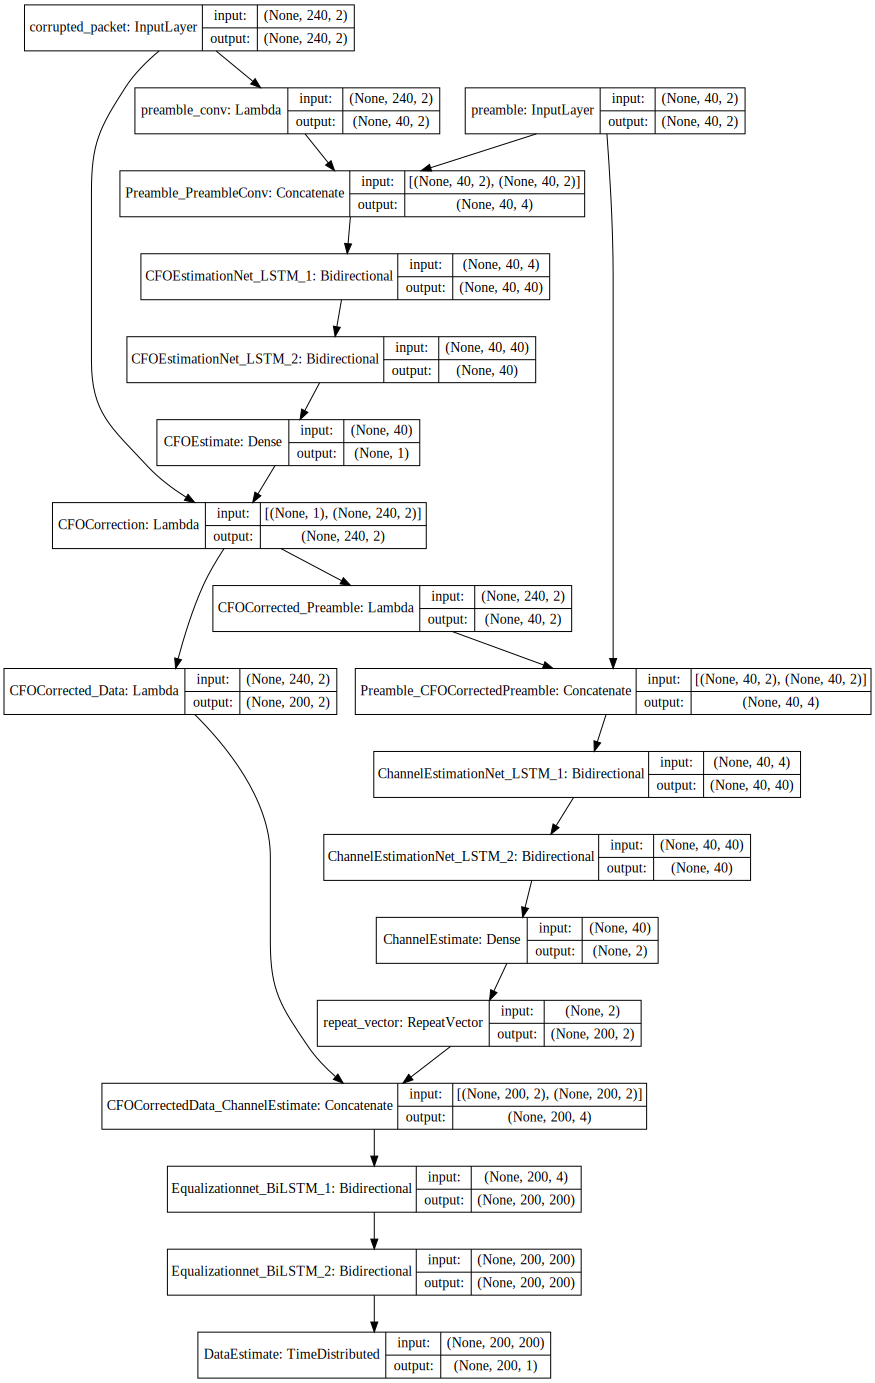

In [7]:
print("Number of training parameters: %d" % model.count_params())
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

## Load modular pretrained weights  and start training

* Note: In this epxeriment, we introduce CFO and Channel loss into the total loss. 

Therefore, given data_length $L$, channel length = 2, the loss function would be:

$$L(w, h) = \frac{1}{L}\sum^{i=L}_{i=1}(y_i - \hat{y}_i)^2 + \frac{1}{2}\sum^{i=2}_{i=1}(c_i - \hat{c}_i)^2 + (cfo - \hat{cfo})^2] $$

In [8]:
model.compile(tf.keras.optimizers.Adam(0.001), 'mse', loss_weights=[1.0, 1.0, 1.0])

In [9]:
tesorboard = TrainValTensorBoard(
    write_graph=False,
    log_dir='./logs/{data_len}::{preamble_len}::{snr}::{omega}::end2end_with_intermediate_loss'.format(
          data_len=DATA_LEN, 
          preamble_len=PREAMBLE_LEN, 
          snr=SNR_TRAIN, 
          omega=OMEGA_TRAIN))
backup_best_model = tf.keras.callbacks.ModelCheckpoint(
    '../models/end2end_with_intermediate_losses.hdf5', 
    save_best_only=True)

try:
    model.load_weights('../models/end2end_with_intermediate_losses.hdf5')
except:
    pass

history = model.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    steps_per_epoch=200,
    validation_steps=20,
    callbacks=[tesorboard, backup_best_model],
    epochs=50,
    initial_epoch=35)

Epoch 36/50
200/200 [==============================] - 281s 1s/step - loss: 3.2093e-04 - DataEstimate_loss: 1.0955e-04 - CFOEstimate_loss: 1.5550e-05 - ChannelEstimate_loss: 1.9583e-04 - val_loss: 2.4212e-04 - val_DataEstimate_loss: 6.2201e-05 - val_CFOEstimate_loss: 8.7319e-06 - val_ChannelEstimate_loss: 1.7119e-04
Epoch 37/50
200/200 [==============================] - 266s 1s/step - loss: 6.3176e-04 - DataEstimate_loss: 2.5386e-04 - CFOEstimate_loss: 4.2569e-05 - ChannelEstimate_loss: 3.3532e-04 - val_loss: 2.3331e-04 - val_DataEstimate_loss: 5.4928e-05 - val_CFOEstimate_loss: 1.0134e-05 - val_ChannelEstimate_loss: 1.6825e-04
Epoch 38/50
200/200 [==============================] - 265s 1s/step - loss: 2.5894e-04 - DataEstimate_loss: 9.3495e-05 - CFOEstimate_loss: 1.1844e-05 - ChannelEstimate_loss: 1.5360e-04 - val_loss: 2.4206e-04 - val_DataEstimate_loss: 9.9343e-05 - val_CFOEstimate_loss: 9.8783e-06 - val_ChannelEstimate_loss: 1.3284e-04
Epoch 39/50
200/200 [=========================

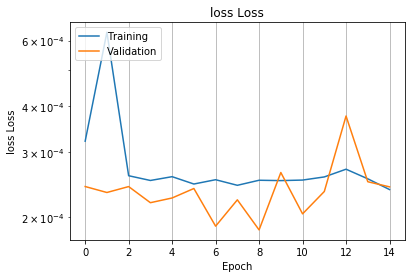

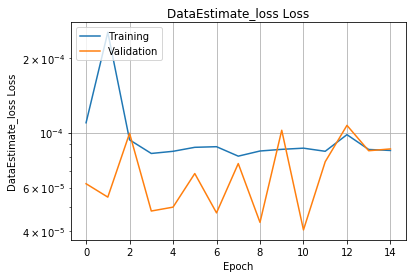

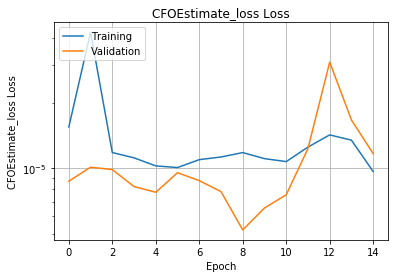

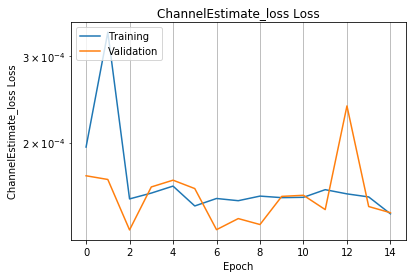

In [10]:
# Source: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
def visualization(history, key):
    plt.plot(history.history[key])
    plt.plot(history.history['val_%s'%key])
    plt.title('%s Loss' % key)
    plt.ylabel('%s Loss' % key)
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.grid()
    plt.semilogy()
    
for key in history.history.keys():
    if 'val' not in key:
        plt.figure()
        visualization(history, key)

## Evaluate on multiple $SNRs$ with/without CFO.

In [14]:
NUM_SAMPLES = 50000

CFOs = [1/50, 1/10000]   # with/without CFO
SNR_RANGE = [0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 40.0, 50.0]

baseline = Baseline()  # MMSE + Classic Demod + Viterbi

In [15]:
def visualize_ber_bler(ber_logs, bler_logs, snr_range, title=''):
    """Helper function to visualize the result."""
    
    baseline_title = 'Baseline (MMSE +Classic Demod + Viterbi)'
    end2nd_title   = 'End-to-End Network'

    fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(15, 7))
    fig.suptitle(title, fontsize=14,)
    ### Plot Bit Error Rate (BER) ###
    left_ax.plot(snr_range, np.array(ber_logs).T[1, :], 'r-^')
    left_ax.plot(snr_range, np.array(ber_logs).T[0, :], 'b--*')
    left_ax.legend([end2nd_title,baseline_title], fontsize=10)
    left_ax.set_xlabel('SNR (in dB)', fontweight='bold')
    left_ax.set_ylabel('Bit Error Rate (BER)', fontweight='bold')
    left_ax.grid(True,'both')
    left_ax.set_xlim(np.min(snr_range), np.max(snr_range))
    left_ax.semilogy()
    ### Plot Block Error Rate (BER) ###
    right_ax.set_xlim(np.min(snr_range), np.max(snr_range))
    right_ax.plot(snr_range, np.array(bler_logs).T[1,:], 'r-^')
    right_ax.plot(snr_range, np.array(bler_logs).T[0,:], 'b--*')
    right_ax.legend([end2nd_title,baseline_title], fontsize=10)
    right_ax.set_xlabel('SNR (in dB)', fontweight='bold')
    right_ax.set_ylabel('Block Error Rate (BLER)', fontweight='bold')
    right_ax.set_xlim(np.min(snr_range), np.max(snr_range))
    right_ax.grid(True,'both')
    right_ax.semilogy()
    
    return fig


SNR_dB = 0.000000
	[Modular]  Ber = 0.45020780 | Bler =1.00000000 - 45.71923s
	[Baseline] Ber = 0.46867090 | Bler =1.00000000 - 428.79717s
SNR_dB = 5.000000
	[Modular]  Ber = 0.23289790 | Bler =0.99998000 - 44.56653s
	[Baseline] Ber = 0.40761730 | Bler =0.99312000 - 427.01165s
SNR_dB = 10.000000
	[Modular]  Ber = 0.00279210 | Bler =0.24914000 - 44.72237s
	[Baseline] Ber = 0.38057950 | Bler =0.94090000 - 426.44853s
SNR_dB = 15.000000
	[Modular]  Ber = 0.00018280 | Bler =0.03612000 - 164.18738s
	[Baseline] Ber = 0.37167260 | Bler =0.91026000 - 427.20388s
SNR_dB = 20.000000
	[Modular]  Ber = 0.00011830 | Bler =0.02366000 - 44.56593s
	[Baseline] Ber = 0.36819110 | Bler =0.89852000 - 425.77103s
SNR_dB = 25.000000
	[Modular]  Ber = 0.00009220 | Bler =0.01844000 - 44.69026s
	[Baseline] Ber = 0.36692330 | Bler =0.89376000 - 426.31997s
SNR_dB = 30.000000
	[Modular]  Ber = 0.00008620 | Bler =0.01724000 - 44.86033s
	[Baseline] Ber = 0.36638640 | Bler =0.89228000 - 426.17042s
SNR_dB = 40.000000
	[

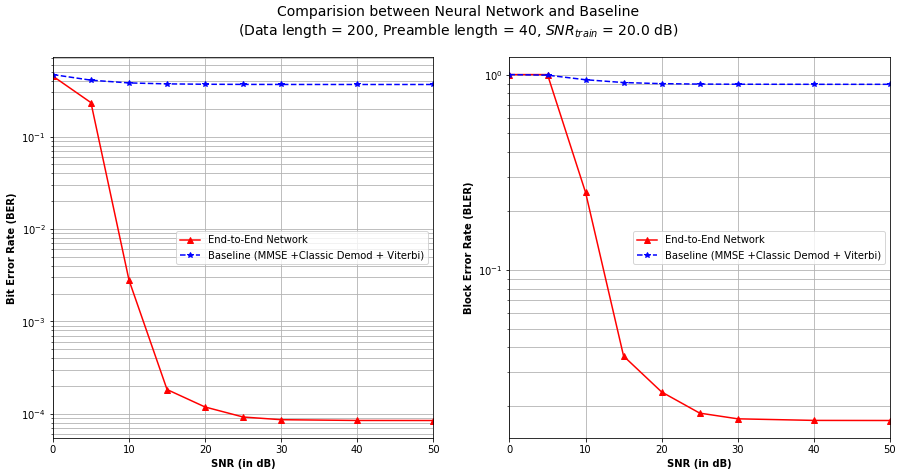

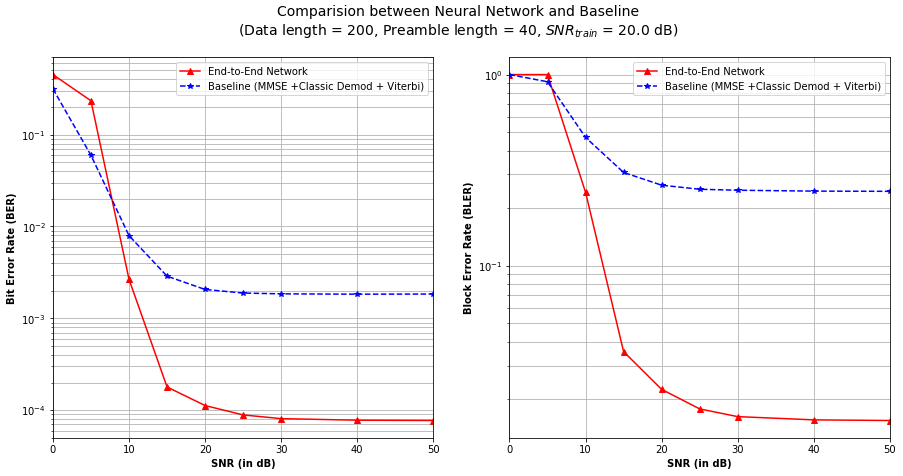

In [16]:
for cfo in CFOs:
    ber_logs, bler_logs = [], []
    for i, snr in enumerate(SNR_RANGE):
        print('SNR_dB = %f' % snr)
        x_test, y_test = next(radio.end2end_data_generator(cfo, 
                                                           snr, 
                                                           batch_size=NUM_SAMPLES, 
                                                           num_cpus=16, 
                                                           seed=2019))
        Y_test = np.squeeze(y_test[0], -1)  #(batch, 100, 1) to (batch, 100)

        # Run Baseline/Neral Receiver
        t1 = time.time()

        # preprocess inputs for baseline
        [preambles, corrupted_packets] = x_test
        preambles = preambles.view(complex)
        convolved_preamble = np.array(corrupted_packets[:, :radio.preamble_len, :]).view(complex)
        convolved_data     = np.array(corrupted_packets[:, radio.preamble_len:, :]).view(complex)
        with mp.Pool(mp.cpu_count()) as pool:
            baseline_estimate = pool.starmap(baseline, [(i, j , k) for i, j, k 
                                                        in zip(convolved_data, convolved_preamble, preambles)])

        t2 = time.time()

        predictions, _, _ = model.predict(x_test, 500)
        nn_estimate = np.squeeze(predictions, -1).round()
        t3 = time.time()

        # Measure BER / BKER for two receivers
        ber, bler       = get_ber_bler(np.array(baseline_estimate), Y_test)
        nn_ber, nn_bler = get_ber_bler(nn_estimate, Y_test)

        print('\t[Modular]  Ber = {:.8f} | Bler ={:.8f} - {:3.5f}s'.format(nn_ber, nn_bler, t3 - t2))
        print('\t[Baseline] Ber = {:.8f} | Bler ={:.8f} - {:3.5f}s'.format(ber, bler, t2-t1))
        ber_logs.append([ber, nn_ber])
        bler_logs.append([bler, nn_bler])
    
    title = 'Comparision between Neural Network and Baseline\n(Data length = 200, Preamble length = 40'\
        ', $SNR_{train}$ = 20.0 dB)'
    
    fig = visualize_ber_bler(ber_logs, bler_logs, SNR_RANGE, title)